# eCommerce Product Recommendation - Part 3

# 1. Load Feature Data

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from imblearn.pipeline import Pipeline 
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [13]:
model_all_data = pd.read_csv('model_all_data.csv')

In [14]:
model_all_data.head()

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,unique_key,label,user_product__total_orders,user_product__add_to_cart_order_mean,...,product__most_hod,product__days_since_prior_order_mean,product__aisle_id,product__department_id,user__order_count,user__product_count,user__days_since_prior_order_mean,user__reordered_mean,user__most_dow,user__most_hod
0,152610,30597,22,6,8,10.0,152610_30597,0,5,2.00,...,9,12.592593,53,16,26,408,10.953804,0.375,6,12
1,152610,15221,22,6,8,10.0,152610_15221,0,8,8.25,...,12,13.653846,84,16,26,408,10.953804,0.375,6,12
2,152610,43772,22,6,8,10.0,152610_43772,0,2,3.00,...,12,12.008565,83,4,26,408,10.953804,0.375,6,12
3,152610,37886,22,6,8,10.0,152610_37886,0,2,3.50,...,14,11.489362,53,16,26,408,10.953804,0.375,6,12
4,152610,37215,22,6,8,10.0,152610_37215,0,1,5.00,...,13,11.490066,98,7,26,408,10.953804,0.375,6,12


In [17]:
unique_key = ['user_id', 'product_id']

raw_features = ['order_number',
                     'order_dow',
                     'order_hour_of_day',
                     'days_since_prior_order',
                     'user_product__total_orders',
                     'user_product__add_to_cart_order_mean',
                     'user_product__reordered_mean',
                     'user_product__most_dow',
                     'user_product__most_hod',
                     'product__total_orders',
                     'product__add_to_cart_order_mean',
                     'product__total_users',
                     'product__reordered_mean',
                     'product__most_dow',
                     'product__most_hod',
                     'product__days_since_prior_order_mean',
                     'user__order_count',
                     'user__product_count',
                     'user__days_since_prior_order_mean',
                     'user__reordered_mean',
                     'user__most_dow',
                     'user__most_hod',
                     'product__aisle_id',
                     'product__department_id',
                     ]
                   
label = ['label']

In [18]:
model_all_data = model_all_data[unique_key + raw_features + label]

In [19]:
model_all_data.head()

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_product__total_orders,user_product__add_to_cart_order_mean,user_product__reordered_mean,user_product__most_dow,...,product__days_since_prior_order_mean,user__order_count,user__product_count,user__days_since_prior_order_mean,user__reordered_mean,user__most_dow,user__most_hod,product__aisle_id,product__department_id,label
0,152610,30597,22,6,8,10.0,5,2.00,0.800,6,...,12.592593,26,408,10.953804,0.375,6,12,53,16,0
1,152610,15221,22,6,8,10.0,8,8.25,0.875,4,...,13.653846,26,408,10.953804,0.375,6,12,84,16,0
2,152610,43772,22,6,8,10.0,2,3.00,0.500,5,...,12.008565,26,408,10.953804,0.375,6,12,83,4,0
3,152610,37886,22,6,8,10.0,2,3.50,0.500,6,...,11.489362,26,408,10.953804,0.375,6,12,53,16,0
4,152610,37215,22,6,8,10.0,1,5.00,0.000,6,...,11.490066,26,408,10.953804,0.375,6,12,98,7,0


# 2. Feature Data Analysis & Tranformation

2.1. Label Ratio

In [20]:
label_count = model_all_data.label.value_counts()
print("Negative label count: ", label_count[0])
print("Positive label count: ", label_count[1])
print("Positive label rate is {:.2f}%".format(
      label_count[1] / (label_count[0] + label_count[1]) * 100) )

Negative label count:  297467
Positive label count:  32339
Positive label rate is 9.81%


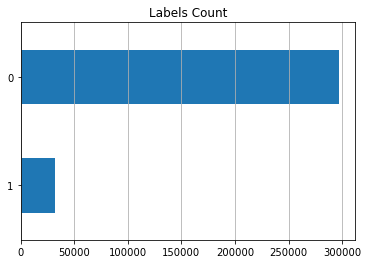

In [21]:
ax = label_count.sort_values().plot(kind='barh', title='Labels Count')
ax.grid(axis="x")

2.2. Null value check

In [22]:
model_all_data.isna().sum()

user_id                                     0
product_id                                  0
order_number                                0
order_dow                                   0
order_hour_of_day                           0
days_since_prior_order                  29995
user_product__total_orders                  0
user_product__add_to_cart_order_mean        0
user_product__reordered_mean                0
user_product__most_dow                      0
user_product__most_hod                      0
product__total_orders                       0
product__add_to_cart_order_mean             0
product__total_users                        0
product__reordered_mean                     0
product__most_dow                           0
product__most_hod                           0
product__days_since_prior_order_mean      726
user__order_count                           0
user__product_count                         0
user__days_since_prior_order_mean           0
user__reordered_mean              

2.3. Categorical Feature Transformation


In [23]:
# One-hot encoding for the `product__department_id` feature.
model_all_data = pd.concat(
    [model_all_data.drop('product__department_id',axis=1),
     pd.get_dummies(model_all_data["product__department_id"],
                    prefix='product__department_id_')],
                     axis=1)

# 3. Split Dataset to Train, Validation and Test

In order to do model training, model selection and evaluation, we split `model_all_data` to three parts: train, validation, test.

In [24]:
# We randomly select 20% users as test data. 
# The remaining data will be used as train & validation data.
test_user_ids = model_all_data.user_id.drop_duplicates().sample(frac=0.2)

train_validation_data = model_all_data[~model_all_data.user_id.isin(test_user_ids)]
test_data = model_all_data[model_all_data.user_id.isin(test_user_ids)]

In [25]:
model_all_data.shape

(329806, 47)

In [26]:
train_validation_data.shape

(262234, 47)

In [27]:
test_data.shape

(67572, 47)

# 4. Model Selection with Cross Validation

4.1. Model Selection with All Features

In [28]:
train_validation_data_x = train_validation_data.drop(['user_id', 'product_id', 'label'],axis=1)
train_validation_data_y = train_validation_data['label']

In [29]:
classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    ]

In [30]:
def build_ml_pipeline(classifier): 
  steps = list()
  steps.append(('fillnan', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0)))
  steps.append(('downSample', RandomUnderSampler()))
  steps.append(('scaler', MinMaxScaler()))
  steps.append(('model', classifier))
  pipeline = Pipeline(steps=steps)
  return pipeline

In [31]:
for classifier in classifiers:
  pipeline = build_ml_pipeline(classifier)
  %time scores = cross_val_score(pipeline, train_validation_data_x, train_validation_data_y, cv=5, scoring='f1')
  print(classifier.__class__.__name__, ': F1 value is %.3f (%.3f)' % (np.mean(scores)*100, np.std(scores)*100))
  print('==============')

Wall time: 8.85 s
LogisticRegression : F1 value is 34.869 (2.531)
Wall time: 13.6 s
DecisionTreeClassifier : F1 value is 24.699 (1.181)
Wall time: 2min 2s
RandomForestClassifier : F1 value is 33.897 (2.844)
Wall time: 1min 3s
AdaBoostClassifier : F1 value is 34.310 (3.437)
Wall time: 3min 13s
GradientBoostingClassifier : F1 value is 35.229 (3.313)


4.2. Feature Selection

In [32]:
pipeline = build_ml_pipeline(GradientBoostingClassifier()) 
pipeline.fit(train_validation_data_x, train_validation_data_y)

Pipeline(steps=[('fillnan', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('downSample', RandomUnderSampler()),
                ('scaler', MinMaxScaler()),
                ('model', GradientBoostingClassifier())])

In [33]:
importances = pipeline.steps[3][1].feature_importances_
feature_names=train_validation_data_x.columns.tolist()

In [34]:
df_importances = pd.DataFrame(
    {"feature":feature_names, "importance":importances}).sort_values("importance", ascending=False)
top15_features = df_importances.head(15)    

In [35]:
# Only use the selected top 15 features in our training data.
train_validation_data_x_select_features = train_validation_data_x[top15_features['feature']]

In [36]:
top15_features

,feature,importance
4,user_product__total_orders,0.355791
16,user__order_count,0.292292
6,user_product__reordered_mean,0.161684
0,order_number,0.075455
12,product__reordered_mean,0.067649
19,user__reordered_mean,0.013393
9,product__total_orders,0.007119
3,days_since_prior_order,0.006445
18,user__days_since_prior_order_mean,0.003409
10,product__add_to_cart_order_mean,0.003181


4.3. Model Selection with Selected Top 15 Features

In [38]:
for classifier in classifiers:
  pipeline = build_ml_pipeline(classifier)
  %time scores = cross_val_score(pipeline, train_validation_data_x_select_features, train_validation_data_y, cv=5, scoring='f1')
  print(classifier.__class__.__name__, ': F1 value is %.3f (%.3f)' % (np.mean(scores)*100, np.std(scores)*100))
  print('==============')

Wall time: 4.71 s
LogisticRegression : F1 value is 34.853 (2.369)
Wall time: 9.15 s
DecisionTreeClassifier : F1 value is 24.944 (1.226)
Wall time: 2min 11s
RandomForestClassifier : F1 value is 33.861 (3.091)
Wall time: 36.6 s
AdaBoostClassifier : F1 value is 34.545 (3.501)
Wall time: 2min 15s
GradientBoostingClassifier : F1 value is 35.344 (3.360)


# 6. Hyper-parameter tuning for GradientBoostingClassifier

Here we use 5% of the data to do hyper-paremter tuning.

In [40]:
sample_user_ids = train_validation_data.user_id.drop_duplicates().sample(frac=0.05)
train_validation_data_sample = train_validation_data[train_validation_data.user_id.isin(sample_user_ids)]

In [41]:
train_validation_data_sample_x = train_validation_data_sample.drop(['user_id', 'product_id', 'label'],axis=1)[top15_features['feature']]
train_validation_data_sample_y = train_validation_data_sample['label']

In [42]:
param_grid = {
    'model__n_estimators': [100,150],
    'model__max_depth': [4,6],
    'model__min_samples_split': [2,4,6],
    'model__learning_rate': [0.005, 0.01],
}

In [43]:
grid = GridSearchCV(build_ml_pipeline(GradientBoostingClassifier()), cv=5, param_grid=param_grid, scoring='f1')
grid.fit(train_validation_data_sample_x, train_validation_data_sample_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('fillnan',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('downSample', RandomUnderSampler()),
                                       ('scaler', MinMaxScaler()),
                                       ('model',
                                        GradientBoostingClassifier())]),
             param_grid={'model__learning_rate': [0.005, 0.01],
                         'model__max_depth': [4, 6],
                         'model__min_samples_split': [2, 4, 6],
                         'model__n_estimators': [100, 150]},
             scoring='f1')

In [44]:
print("Best F1 value is %.3f" % grid.best_score_)
print("Params are %s" % grid.best_params_)

Best F1 value is 0.321
Params are {'model__learning_rate': 0.005, 'model__max_depth': 4, 'model__min_samples_split': 6, 'model__n_estimators': 150}


# 7. Train the final GradientBoostingClassifier 

7.1. Train the final model with all training+validation data and the best hyper-parameters.

In [45]:
pipeline = build_ml_pipeline(GradientBoostingClassifier(
    n_estimators=100,
    min_samples_split=2,
    max_depth=4,
    learning_rate=0.005,
))

pipeline.fit(train_validation_data_x_select_features, train_validation_data_y)

Pipeline(steps=[('fillnan', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('downSample', RandomUnderSampler()),
                ('scaler', MinMaxScaler()),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.005, max_depth=4))])

In [46]:
importances = pipeline.steps[3][1].feature_importances_
feature_names=train_validation_data_x_select_features.columns.tolist()
df_importances = pd.DataFrame(
    {"feature":feature_names, "importance":importances}).sort_values("importance", ascending=False)
df_importances.head(15)

,feature,importance
0,user_product__total_orders,0.322081
1,user__order_count,0.317918
2,user_product__reordered_mean,0.299668
3,order_number,0.033873
4,product__reordered_mean,0.024817
8,user__days_since_prior_order_mean,0.000825
6,product__total_orders,0.000413
13,product__department_id__13,0.000348
14,user_product__add_to_cart_order_mean,0.000058
5,user__reordered_mean,0.000000


# 8. Evaluate model on Test Data 

8.1. Predict product reorder on Test Data

In [47]:
test_data_x_selected_features = test_data.drop(['user_id', 'product_id', 'label'],axis=1)[top15_features['feature']]
test_data_y = test_data['label']

In [48]:
predict_y = pipeline.predict(test_data_x_selected_features)

In [49]:
df_output = pd.DataFrame(
    {"user_id":test_data.user_id, "product_id":test_data.product_id, "predict":predict_y, "label":test_data.label})   

In [50]:
df_output.head()

,user_id,product_id,predict,label
255,112604,30597,0,0
256,112604,46676,0,0
257,112604,13176,1,0
258,112604,16797,0,0
259,112604,7930,0,0


In [51]:
predict_y_prob = pipeline.predict_proba(test_data_x_selected_features)[:,1]

8.2. Analyze classification result

In [54]:
acc = accuracy_score(test_data_y, predict_y)
f1 = f1_score(test_data_y, predict_y)
pre = precision_score(test_data_y, predict_y)
rec = recall_score(test_data_y, predict_y)
auc = roc_auc_score(test_data_y, predict_y_prob) 

In [55]:
print("Model evaluation result on test data: ")
print("F1 Score : {:.4%}".format(f1))
print("ROC AUC : {:.4%}".format(auc))
print("Accuracy : {:.4%}".format(acc))
print("Precision : {:.4%}".format(pre))
print("Recall : {:.4%}".format(rec))

Model evaluation result on test data: 
F1 Score : 34.1652%
ROC AUC : 79.4657%
Accuracy : 74.3518%
Precision : 22.6583%
Recall : 69.4196%
